In [13]:
import numpy as np


class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [6]:
from sklearn.datasets import load_boston

In [7]:
data = load_boston()

In [49]:
losses = []

In [50]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 210.832
Epoch: 101, Loss: 8.064
Epoch: 201, Loss: 5.622
Epoch: 301, Loss: 4.126
Epoch: 401, Loss: 4.380
Epoch: 501, Loss: 4.099
Epoch: 601, Loss: 4.445
Epoch: 701, Loss: 3.716
Epoch: 801, Loss: 3.768
Epoch: 901, Loss: 2.964
Epoch: 1001, Loss: 3.391
Epoch: 1101, Loss: 3.116
Epoch: 1201, Loss: 3.693
Epoch: 1301, Loss: 3.133
Epoch: 1401, Loss: 3.540
Epoch: 1501, Loss: 3.155
Epoch: 1601, Loss: 3.801
Epoch: 1701, Loss: 3.183
Epoch: 1801, Loss: 3.478
Epoch: 1901, Loss: 3.554
Epoch: 2001, Loss: 3.158
Epoch: 2101, Loss: 3.114
Epoch: 2201, Loss: 3.314
Epoch: 2301, Loss: 3.374
Epoch: 2401, Loss: 2.714
Epoch: 2501, Loss: 3.229
Epoch: 2601, Loss: 2.775
Epoch: 2701, Loss: 3.312
Epoch: 2801, Loss: 3.002
Epoch: 2901, Loss: 3.187
Epoch: 3001, Loss: 2.935
Epoch: 3101, Loss: 3.097
Epoch: 3201, Loss: 3.020
Epoch: 3301, Loss: 2.978
Epoch: 3401, Loss: 2.732
Epoch: 3501, Loss: 3.067
Epoch: 3601, Loss: 2.493
Epoch: 3701, Loss: 2.988
Epoch: 3801, Loss: 2.607
Epoc

In [51]:
import matplotlib.pyplot as plt

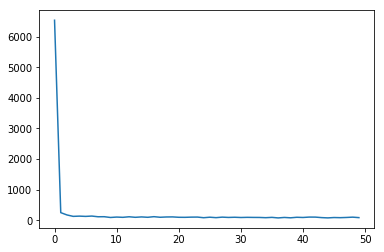

In [54]:
plt.plot(range(len(losses)), losses)

In [18]:
W2.value

array([[  6.06675992],
       [  8.23298865],
       [  8.80431613],
       [-13.36338757],
       [  9.65316777],
       [  5.96190503],
       [ 10.99998584],
       [  3.48275087],
       [  3.78735499],
       [ 12.03614078]])

In [19]:
X_ = data['data']

In [21]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [26]:
import keras

In [32]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [47]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [48]:
model.fit(X_, y_, epochs=5000, batch_size=32)

Epoch 1/5000
506/506 [==============================] - 0s 482us/step - loss: 143.4432 - mean_squared_error: 143.4432
Epoch 2/5000
506/506 [==============================] - 0s 42us/step - loss: 82.3686 - mean_squared_error: 82.3686
Epoch 3/5000
506/506 [==============================] - 0s 42us/step - loss: 77.3528 - mean_squared_error: 77.3528
Epoch 4/5000
506/506 [==============================] - 0s 41us/step - loss: 76.8472 - mean_squared_error: 76.8472
Epoch 5/5000
506/506 [==============================] - 0s 50us/step - loss: 75.8336 - mean_squared_error: 75.8336
Epoch 6/5000
506/506 [==============================] - 0s 50us/step - loss: 78.7476 - mean_squared_error: 78.7476
Epoch 7/5000
506/506 [==============================] - 0s 40us/step - loss: 79.6914 - mean_squared_error: 79.6914
Epoch 8/5000
506/506 [==============================] - 0s 45us/step - loss: 78.6502 - mean_squared_error: 78.6502
Epoch 9/5000
506/506 [==============================] - 0s 52us/step - loss: 

506/506 [==============================] - 0s 36us/step - loss: 85.1061 - mean_squared_error: 85.1061
Epoch 72/5000
506/506 [==============================] - 0s 42us/step - loss: 85.9251 - mean_squared_error: 85.9251
Epoch 73/5000
506/506 [==============================] - 0s 61us/step - loss: 85.6596 - mean_squared_error: 85.6596
Epoch 74/5000
506/506 [==============================] - 0s 69us/step - loss: 85.0436 - mean_squared_error: 85.0436
Epoch 75/5000
506/506 [==============================] - 0s 63us/step - loss: 84.7368 - mean_squared_error: 84.7368
Epoch 76/5000
506/506 [==============================] - 0s 59us/step - loss: 84.8656 - mean_squared_error: 84.8656
Epoch 77/5000
506/506 [==============================] - 0s 46us/step - loss: 84.8080 - mean_squared_error: 84.8080
Epoch 78/5000
506/506 [==============================] - 0s 57us/step - loss: 85.2302 - mean_squared_error: 85.2302
Epoch 79/5000
506/506 [==============================] - 0s 63us/step - loss: 85.5889 

506/506 [==============================] - 0s 62us/step - loss: 85.3288 - mean_squared_error: 85.3288
Epoch 142/5000
506/506 [==============================] - 0s 49us/step - loss: 85.0092 - mean_squared_error: 85.0092
Epoch 143/5000
506/506 [==============================] - 0s 64us/step - loss: 85.2259 - mean_squared_error: 85.2259
Epoch 144/5000
506/506 [==============================] - 0s 80us/step - loss: 85.1957 - mean_squared_error: 85.1957
Epoch 145/5000
506/506 [==============================] - 0s 66us/step - loss: 85.4370 - mean_squared_error: 85.4370
Epoch 146/5000
506/506 [==============================] - 0s 56us/step - loss: 85.3190 - mean_squared_error: 85.3190
Epoch 147/5000
506/506 [==============================] - 0s 56us/step - loss: 85.7632 - mean_squared_error: 85.7632
Epoch 148/5000
506/506 [==============================] - 0s 61us/step - loss: 84.8774 - mean_squared_error: 84.8774
Epoch 149/5000
506/506 [==============================] - 0s 55us/step - loss: 

506/506 [==============================] - 0s 54us/step - loss: 84.9909 - mean_squared_error: 84.9909
Epoch 212/5000
506/506 [==============================] - 0s 52us/step - loss: 84.8783 - mean_squared_error: 84.8783
Epoch 213/5000
506/506 [==============================] - 0s 65us/step - loss: 85.1552 - mean_squared_error: 85.1552
Epoch 214/5000
506/506 [==============================] - 0s 55us/step - loss: 85.5238 - mean_squared_error: 85.5238
Epoch 215/5000
506/506 [==============================] - 0s 59us/step - loss: 85.6824 - mean_squared_error: 85.6824
Epoch 216/5000
506/506 [==============================] - 0s 50us/step - loss: 85.4589 - mean_squared_error: 85.4589
Epoch 217/5000
506/506 [==============================] - 0s 47us/step - loss: 84.9196 - mean_squared_error: 84.9196
Epoch 218/5000
506/506 [==============================] - 0s 74us/step - loss: 85.6688 - mean_squared_error: 85.6688
Epoch 219/5000
506/506 [==============================] - 0s 48us/step - loss: 

506/506 [==============================] - 0s 60us/step - loss: 84.9341 - mean_squared_error: 84.9341
Epoch 282/5000
506/506 [==============================] - 0s 64us/step - loss: 85.3827 - mean_squared_error: 85.3827
Epoch 283/5000
506/506 [==============================] - 0s 85us/step - loss: 85.2546 - mean_squared_error: 85.2546
Epoch 284/5000
506/506 [==============================] - 0s 71us/step - loss: 85.3267 - mean_squared_error: 85.3267
Epoch 285/5000
506/506 [==============================] - 0s 63us/step - loss: 84.6884 - mean_squared_error: 84.6884
Epoch 286/5000
506/506 [==============================] - 0s 61us/step - loss: 84.8015 - mean_squared_error: 84.8015
Epoch 287/5000
506/506 [==============================] - 0s 74us/step - loss: 85.5370 - mean_squared_error: 85.5370
Epoch 288/5000
506/506 [==============================] - 0s 49us/step - loss: 84.8321 - mean_squared_error: 84.8321
Epoch 289/5000
506/506 [==============================] - 0s 46us/step - loss: 

506/506 [==============================] - 0s 61us/step - loss: 85.3702 - mean_squared_error: 85.3702
Epoch 352/5000
506/506 [==============================] - 0s 49us/step - loss: 85.0057 - mean_squared_error: 85.0057
Epoch 353/5000
506/506 [==============================] - 0s 54us/step - loss: 85.0804 - mean_squared_error: 85.0804
Epoch 354/5000
506/506 [==============================] - 0s 59us/step - loss: 84.9107 - mean_squared_error: 84.9107
Epoch 355/5000
506/506 [==============================] - 0s 54us/step - loss: 85.5194 - mean_squared_error: 85.5194
Epoch 356/5000
506/506 [==============================] - 0s 46us/step - loss: 85.1383 - mean_squared_error: 85.1383
Epoch 357/5000
506/506 [==============================] - 0s 52us/step - loss: 85.1880 - mean_squared_error: 85.1880
Epoch 358/5000
506/506 [==============================] - 0s 70us/step - loss: 85.0883 - mean_squared_error: 85.0883
Epoch 359/5000
506/506 [==============================] - 0s 51us/step - loss: 

506/506 [==============================] - 0s 55us/step - loss: 85.0753 - mean_squared_error: 85.0753
Epoch 422/5000
506/506 [==============================] - 0s 61us/step - loss: 84.9265 - mean_squared_error: 84.9265
Epoch 423/5000
506/506 [==============================] - 0s 61us/step - loss: 84.6310 - mean_squared_error: 84.6310
Epoch 424/5000
506/506 [==============================] - 0s 47us/step - loss: 85.5256 - mean_squared_error: 85.5256
Epoch 425/5000
506/506 [==============================] - 0s 67us/step - loss: 85.1650 - mean_squared_error: 85.1650
Epoch 426/5000
506/506 [==============================] - 0s 70us/step - loss: 84.7339 - mean_squared_error: 84.7339
Epoch 427/5000
506/506 [==============================] - 0s 53us/step - loss: 85.3687 - mean_squared_error: 85.3687
Epoch 428/5000
506/506 [==============================] - 0s 51us/step - loss: 85.2038 - mean_squared_error: 85.2038
Epoch 429/5000
506/506 [==============================] - 0s 59us/step - loss: 

506/506 [==============================] - 0s 79us/step - loss: 85.2048 - mean_squared_error: 85.2048
Epoch 492/5000
506/506 [==============================] - 0s 58us/step - loss: 84.9330 - mean_squared_error: 84.9330
Epoch 493/5000
506/506 [==============================] - 0s 57us/step - loss: 85.4924 - mean_squared_error: 85.4924
Epoch 494/5000
506/506 [==============================] - 0s 64us/step - loss: 84.7943 - mean_squared_error: 84.7943
Epoch 495/5000
506/506 [==============================] - 0s 66us/step - loss: 85.0604 - mean_squared_error: 85.0604
Epoch 496/5000
506/506 [==============================] - 0s 66us/step - loss: 84.1923 - mean_squared_error: 84.1923
Epoch 497/5000
506/506 [==============================] - 0s 63us/step - loss: 85.1488 - mean_squared_error: 85.1488
Epoch 498/5000
506/506 [==============================] - 0s 59us/step - loss: 84.8337 - mean_squared_error: 84.8337
Epoch 499/5000
506/506 [==============================] - 0s 71us/step - loss: 

506/506 [==============================] - 0s 53us/step - loss: 84.6124 - mean_squared_error: 84.6124
Epoch 562/5000
506/506 [==============================] - 0s 58us/step - loss: 84.9155 - mean_squared_error: 84.9155
Epoch 563/5000
506/506 [==============================] - 0s 66us/step - loss: 83.9864 - mean_squared_error: 83.9864
Epoch 564/5000
506/506 [==============================] - 0s 58us/step - loss: 85.3675 - mean_squared_error: 85.3675
Epoch 565/5000
506/506 [==============================] - 0s 54us/step - loss: 85.5496 - mean_squared_error: 85.5496
Epoch 566/5000
506/506 [==============================] - 0s 48us/step - loss: 85.0878 - mean_squared_error: 85.0878
Epoch 567/5000
506/506 [==============================] - 0s 46us/step - loss: 84.9054 - mean_squared_error: 84.9054
Epoch 568/5000
506/506 [==============================] - 0s 65us/step - loss: 84.8235 - mean_squared_error: 84.8235
Epoch 569/5000
506/506 [==============================] - 0s 61us/step - loss: 

506/506 [==============================] - 0s 57us/step - loss: 84.7186 - mean_squared_error: 84.7186
Epoch 632/5000
506/506 [==============================] - 0s 79us/step - loss: 85.0211 - mean_squared_error: 85.0211
Epoch 633/5000
506/506 [==============================] - 0s 52us/step - loss: 85.1120 - mean_squared_error: 85.1120
Epoch 634/5000
506/506 [==============================] - 0s 59us/step - loss: 85.1935 - mean_squared_error: 85.1935
Epoch 635/5000
506/506 [==============================] - 0s 51us/step - loss: 84.9476 - mean_squared_error: 84.9476
Epoch 636/5000
506/506 [==============================] - 0s 70us/step - loss: 84.9757 - mean_squared_error: 84.9757
Epoch 637/5000
506/506 [==============================] - 0s 50us/step - loss: 85.0822 - mean_squared_error: 85.0822
Epoch 638/5000
506/506 [==============================] - 0s 42us/step - loss: 84.7716 - mean_squared_error: 84.7716
Epoch 639/5000
506/506 [==============================] - 0s 48us/step - loss: 

506/506 [==============================] - 0s 66us/step - loss: 85.0464 - mean_squared_error: 85.0464
Epoch 702/5000
506/506 [==============================] - 0s 75us/step - loss: 85.1333 - mean_squared_error: 85.1333
Epoch 703/5000
506/506 [==============================] - 0s 63us/step - loss: 84.9138 - mean_squared_error: 84.9138
Epoch 704/5000
506/506 [==============================] - 0s 55us/step - loss: 86.4281 - mean_squared_error: 86.4281
Epoch 705/5000
506/506 [==============================] - 0s 59us/step - loss: 85.3473 - mean_squared_error: 85.3473
Epoch 706/5000
506/506 [==============================] - 0s 66us/step - loss: 84.4789 - mean_squared_error: 84.4789
Epoch 707/5000
506/506 [==============================] - 0s 59us/step - loss: 85.0255 - mean_squared_error: 85.0255
Epoch 708/5000
506/506 [==============================] - 0s 73us/step - loss: 85.2653 - mean_squared_error: 85.2653
Epoch 709/5000
506/506 [==============================] - 0s 60us/step - loss: 

506/506 [==============================] - 0s 52us/step - loss: 84.8576 - mean_squared_error: 84.8576
Epoch 772/5000
506/506 [==============================] - 0s 70us/step - loss: 84.9224 - mean_squared_error: 84.9224
Epoch 773/5000
506/506 [==============================] - 0s 55us/step - loss: 84.8505 - mean_squared_error: 84.8505
Epoch 774/5000
506/506 [==============================] - 0s 53us/step - loss: 85.3900 - mean_squared_error: 85.3900
Epoch 775/5000
506/506 [==============================] - 0s 55us/step - loss: 85.3227 - mean_squared_error: 85.3227
Epoch 776/5000
506/506 [==============================] - 0s 48us/step - loss: 84.9115 - mean_squared_error: 84.9115
Epoch 777/5000
506/506 [==============================] - 0s 52us/step - loss: 85.5220 - mean_squared_error: 85.5220
Epoch 778/5000
506/506 [==============================] - 0s 47us/step - loss: 85.1809 - mean_squared_error: 85.1809
Epoch 779/5000
506/506 [==============================] - 0s 56us/step - loss: 

506/506 [==============================] - 0s 44us/step - loss: 85.5057 - mean_squared_error: 85.5057
Epoch 842/5000
506/506 [==============================] - 0s 69us/step - loss: 85.2541 - mean_squared_error: 85.2541
Epoch 843/5000
506/506 [==============================] - 0s 85us/step - loss: 85.0925 - mean_squared_error: 85.0925
Epoch 844/5000
506/506 [==============================] - 0s 59us/step - loss: 85.0701 - mean_squared_error: 85.0701
Epoch 845/5000
506/506 [==============================] - 0s 65us/step - loss: 85.4431 - mean_squared_error: 85.4431
Epoch 846/5000
506/506 [==============================] - 0s 52us/step - loss: 84.5982 - mean_squared_error: 84.5982
Epoch 847/5000
506/506 [==============================] - 0s 51us/step - loss: 85.2270 - mean_squared_error: 85.2270
Epoch 848/5000
506/506 [==============================] - 0s 82us/step - loss: 84.3814 - mean_squared_error: 84.3814
Epoch 849/5000
506/506 [==============================] - 0s 77us/step - loss: 

KeyboardInterrupt: 